In [1]:
import torch
print(torch.__version__)

2.2.1


In [4]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from Euler_1stOrderForward import getEulerBOLD
from signal_pytorch import csd
import json
import sys
import numpy as np
from scipy.signal import csd as scipy_csd
from torch.optim.lr_scheduler import ExponentialLR

device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
x_train_tensor, y_train_tensor = getEulerBOLD(sigma=torch.tensor(0.8, requires_grad=True), mu=torch.tensor(0.3, requires_grad=True), lamb=torch.tensor(0.5, requires_grad=True), alpha=1.0, beta=torch.tensor(1.0, requires_grad=True), noise=True, length=1000)
f2, csdy = csd(y_train_tensor, y_train_tensor, fs=100, noverlap=None,  window='hamming', scaling='density', nfft=4096, nperseg=1000)
# f2, csdy = csd(target, target, fs=0.5, noverlap=None,  window='hamming', scaling='density', nfft=4096, nperseg=200)
# y_train_tensor = np.loadtxt('./time_series/sub-001-PLCB-ROI0.txt', delimiter=',')

def get_torch_rand(min, max):
    return torch.rand(()) * (max - min) + min


class TimeDomainModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(get_torch_rand(0.5, 0.6))
        self.mu = nn.Parameter(get_torch_rand(0.1, 0.2))
        self.lamb = nn.Parameter(get_torch_rand(0.3, 0.4))
        self.beta = nn.Parameter(get_torch_rand(0.8, 0.9))


    def forward(self):
        #GET BOLD SIGNAL from PDCM WITH NOISE ADDED
        _, yhat = getEulerBOLD(sigma=self.sigma, mu=self.mu, lamb=self.lamb, alpha=1.0, beta=self.beta, noise=True, length=1000)
        yhat = torch.stack(yhat)
        return yhat
        # return torch.tensor(yhat, requires_grad=True)

    



def complex_mse_loss(output):
    f1, csdx = csd(output, output, fs=100, noverlap=None,  window='hamming', scaling='density', nfft=4096, nperseg=1000)
    mse_real = torch.mean(torch.abs(torch.real(csdx) - torch.real(csdy))**2)
    mse_imaginary = torch.mean(torch.abs(torch.imag(csdx) - torch.imag(csdy))**2)
    loss = mse_real + mse_imaginary
    return loss


def train():
    model = TimeDomainModel().to(device)
    lr = 0.001
    n_epochs = 100
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = ExponentialLR(optimizer, gamma=0.8)

    model.train()
    losses = []
    for epoch in range(n_epochs):
        print("Epoch: ", epoch)
        yhat = model()
        loss = complex_mse_loss(yhat)
        print("Loss: ", loss)
        print("Params: ", model.sigma, model.mu, model.lamb, model.beta)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())
        

    # Save losses array as JSON
    with open('losses.json', 'w') as f:
        json.dump(losses, f)

def train_multiple():
    lr = 0.2
    # scheduler = ExponentialLR(optimizer, gamma=0.9)

    num_initializations = 5
    models = [TimeDomainModel().to(device) for _ in range(num_initializations)]

# Train each instance separately using gradient descent
    num_epochs = 10
    model_losses = []
    for model in models:
        losses = []
        optimizer = optim.Adam(model.parameters(), lr=lr)
        for epoch in range(num_epochs):
            # Forward pass
            outputs = model()
            loss = complex_mse_loss(outputs)
            print(loss)
            losses.append(loss.item())
        
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model_losses.append(losses)

    # Evaluate the performance of each instance based on the final loss

    # Select the instance with the lowest loss
    best_model_idx = min(range(len(model_losses)), key=lambda i: model_losses[i][-1])
    print(best_model_idx, model_losses[best_model_idx][-1])

torch.set_printoptions(precision=8)
train()

Input data is complex, switching to return_onesided=False
Epoch:  0
Input data is complex, switching to return_onesided=False
Loss:  tensor(0.00015473, grad_fn=<AddBackward0>)
Params:  Parameter containing:
tensor(0.50796485, requires_grad=True) Parameter containing:
tensor(0.10217706, requires_grad=True) Parameter containing:
tensor(0.30262911, requires_grad=True) Parameter containing:
tensor(0.85658109, requires_grad=True)
Epoch:  1
Input data is complex, switching to return_onesided=False
Loss:  tensor(0.00015865, grad_fn=<AddBackward0>)
Params:  Parameter containing:
tensor(0.50896484, requires_grad=True) Parameter containing:
tensor(0.10317705, requires_grad=True) Parameter containing:
tensor(0.30362904, requires_grad=True) Parameter containing:
tensor(0.85758108, requires_grad=True)
Epoch:  2
Input data is complex, switching to return_onesided=False
Loss:  tensor(0.00019624, grad_fn=<AddBackward0>)
Params:  Parameter containing:
tensor(0.50996560, requires_grad=True) Parameter co

In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import optuna
import json

def objective(trial):
    # Define search space for hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 3e-1, log=True)
    gamma = trial.suggest_float("gamma", 0.5, 0.99)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

    model = TimeDomainModel().to(device)
    n_epochs = 15
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ExponentialLR(optimizer, gamma=gamma)

    model.train()
    losses = []
    for epoch in range(n_epochs):
        yhat = model()
        loss = complex_mse_loss(yhat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
    print("Params: ", model.mtt, model.sigma, model.mu, model.lamb, model.c, model.beta)
    
    return min(losses)  # Optimize for minimum loss

def train_optuna():
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)

    # Print best hyperparameters and best score
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    # Save losses array as JSON
    with open('losses_opt.json', 'w') as f:
        json.dump(trial.value, f)

    # Save final model's parameters (MTT) in a text file
    with open('final_mtt.txt', 'w') as f:
        f.write(str(trial.params["lr"]))  # Save the best learning rate

    print("Best learning rate:", trial.params["lr"])

train_optuna()

[I 2024-05-12 23:46:39,740] A new study created in memory with name: no-name-c2b80326-1db0-444b-89e4-dfb90bc98d2d


Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Params:  Parameter containing:
tensor(1.02665901, requires_grad=True) Parameter containing:
tensor(0.79461068, requires_grad=True)

[I 2024-05-13 00:16:40,065] Trial 0 finished with value: 2.4760808514656674e-07 and parameters: {'lr': 0.14803038900155097, 'gamma': 0.6294666433544825, 'weight_decay': 8.374122099040337e-05}. Best is trial 0 with value: 2.4760808514656674e-07.


Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Params:  Parameter containing:
tensor(1.00130832, requires_grad=True) Parameter containing:
tensor(0.50726324, requires_grad=True)

[I 2024-05-13 00:45:46,276] Trial 1 finished with value: 5.7538745750207454e-05 and parameters: {'lr': 2.7890544448429146e-05, 'gamma': 0.5808591371053577, 'weight_decay': 2.316602255015945e-05}. Best is trial 0 with value: 2.4760808514656674e-07.


Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Params:  Parameter containing:
tensor(1.08861685, requires_grad=True) Parameter containing:
tensor(0.58746260, requires_grad=True)

[I 2024-05-13 01:14:19,104] Trial 2 finished with value: 7.686966273467988e-05 and parameters: {'lr': 2.984964882302587e-05, 'gamma': 0.7633744805443266, 'weight_decay': 0.00021111816920392924}. Best is trial 0 with value: 2.4760808514656674e-07.


Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Params:  Parameter containing:
tensor(nan, requires_grad=True) Parameter containing:
tensor(nan, requires_grad=True) Parameter con

[I 2024-05-13 01:45:18,945] Trial 3 finished with value: 3.96687447334898e-08 and parameters: {'lr': 0.1615808461070963, 'gamma': 0.7038600132901144, 'weight_decay': 0.00026576004491107847}. Best is trial 3 with value: 3.96687447334898e-08.


Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Params:  Parameter containing:
tensor(1.07645357, requires_grad=True) Parameter containing:
tensor(0.53673857, requires_grad=True)

[I 2024-05-13 02:21:29,832] Trial 4 finished with value: 8.909941971069202e-05 and parameters: {'lr': 0.00014973645511077275, 'gamma': 0.8828043638301142, 'weight_decay': 0.000114676703715708}. Best is trial 3 with value: 3.96687447334898e-08.


Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Params:  Parameter containing:
tensor(1.04506159, requires_grad=True) Parameter containing:
tensor(0.54147923, requires_grad=True)

[I 2024-05-13 02:58:06,928] Trial 5 finished with value: 0.00017106486484408379 and parameters: {'lr': 1.3200617570682114e-05, 'gamma': 0.7741055628000657, 'weight_decay': 8.895314384688845e-05}. Best is trial 3 with value: 3.96687447334898e-08.


Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Params:  Parameter containing:
tensor(nan, requires_grad=True) Parameter containing:
tensor(nan, requires_grad=True) Parameter con

[I 2024-05-13 03:30:14,460] Trial 6 finished with value: 1.3689939351024805e-06 and parameters: {'lr': 0.19832745277965153, 'gamma': 0.8785752243851999, 'weight_decay': 0.00023955523328465819}. Best is trial 3 with value: 3.96687447334898e-08.


Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Params:  Parameter containing:
tensor(1.01859200, requires_grad=True) Parameter containing:
tensor(0.53884673, requires_grad=True)

[I 2024-05-13 04:06:04,262] Trial 7 finished with value: 4.670714042731561e-05 and parameters: {'lr': 1.5710686555516198e-05, 'gamma': 0.8132181746848357, 'weight_decay': 0.00010690355121657936}. Best is trial 3 with value: 3.96687447334898e-08.


Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Params:  Parameter containing:
tensor(1.05116963, requires_grad=True) Parameter containing:
tensor(0.69895798, requires_grad=True)

[I 2024-05-13 04:40:15,259] Trial 8 finished with value: 4.587361246422006e-08 and parameters: {'lr': 0.054405310093101705, 'gamma': 0.6716510016724089, 'weight_decay': 3.808399246636142e-05}. Best is trial 3 with value: 3.96687447334898e-08.


Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Params:  Parameter containing:
tensor(1.10449994, requires_grad=True) Parameter containing:
tensor(0.63742483, requires_grad=True)

[I 2024-05-13 05:14:31,949] Trial 9 finished with value: 1.7000838852254674e-05 and parameters: {'lr': 0.017489714324832907, 'gamma': 0.6928178519613257, 'weight_decay': 2.961028300877959e-05}. Best is trial 3 with value: 3.96687447334898e-08.


Best trial:
  Value: 3.96687447334898e-08
  Params: 
    lr: 0.1615808461070963
    gamma: 0.7038600132901144
    weight_decay: 0.00026576004491107847
Best learning rate: 0.1615808461070963


In [48]:
train()

Epoch:  0
Input data is complex, switching to return_onesided=False
Loss:  tensor(0.02052734, grad_fn=<AddBackward0>)
Params:  Parameter containing:
tensor(0.50091839, requires_grad=True) Parameter containing:
tensor(0.10752176, requires_grad=True) Parameter containing:
tensor(0.34239542, requires_grad=True) Parameter containing:
tensor(0.85222644, requires_grad=True)
Epoch:  1
Input data is complex, switching to return_onesided=False
Loss:  tensor(0.00958761, grad_fn=<AddBackward0>)
Params:  Parameter containing:
tensor(0.45091891, requires_grad=True) Parameter containing:
tensor(0.15752175, requires_grad=True) Parameter containing:
tensor(0.39239541, requires_grad=True) Parameter containing:
tensor(0.80222642, requires_grad=True)
Epoch:  2
Input data is complex, switching to return_onesided=False
Loss:  tensor(0.00345655, grad_fn=<AddBackward0>)
Params:  Parameter containing:
tensor(0.42190713, requires_grad=True) Parameter containing:
tensor(0.20535070, requires_grad=True) Parameter

Input data is complex, switching to return_onesided=False
0
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
1
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data

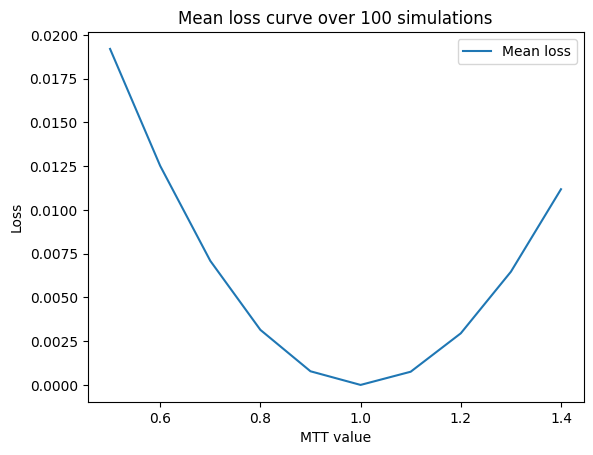

In [64]:
def complex_mse_loss(output):
    f1, csdx = csd(output, output, fs=100, noverlap=None,  window='hamming', scaling='density', nfft=4096, nperseg=1000)
    mse_real = torch.mean(torch.abs(torch.real(csdx) - torch.real(csdy))**2)
    mse_imaginary = torch.mean(torch.abs(torch.imag(csdx) - torch.imag(csdy))**2)
    loss = mse_real + mse_imaginary
    return loss


#fix alpha, change beta
# simulated signal -> alpha and beta 1 -> calculate csd
# observed_bold = np.loadtxt('./time_series/sub-001-PLCB-ROI0.txt', delimiter=',')
x_train_tensor, observed_bold  = getEulerBOLD(torch.tensor(0.8, requires_grad=True), torch.tensor(0.3, requires_grad=True), torch.tensor(0.5, requires_grad=True), 1.0, torch.tensor(1.0, requires_grad=True), True, 1000)

_, csdy = csd(observed_bold, observed_bold, fs=100, noverlap=None,  window='hamming', scaling='density', nfft=4096, nperseg=1000)
all_losses = []
betas = np.arange(0.5, 1.5, 0.1)
mus = np.arange(0.1, 0.5, 0.1)
lambdas = np.arange(0.1, 1.0, 0.1)
sigmas = np.arange(0.5, 1.1, 0.1)
beta = 1.0
mu = 0.3
sigma = 0.8
lamb = 0.5
num_sims = 25

for i in range(num_sims):
    print(i)
    losses = []
    for mu in mus:
        for sigma in sigmas:
            _, bold = getEulerBOLD(torch.tensor(sigma), torch.tensor(mu), torch.tensor(lamb), 1.0, torch.tensor(beta), True, 1000)
            bold = torch.stack(bold)
            loss = complex_mse_loss(bold)
            losses.append(loss.detach().numpy())
    all_losses.append(losses)

all_losses = np.array(all_losses)

mean_loss = np.nanmean(all_losses, axis=0)
std_deviation_loss = np.nanstd(all_losses, axis=0)

print(std_deviation_loss)

plt.xlabel('MTT value')
plt.ylabel('Loss')
plt.title('Mean loss curve over 100 simulations')
plt.plot(betas, mean_loss, label='Mean loss')
plt.legend()
plt.fill_between(betas, mean_loss-std_deviation_loss, mean_loss+std_deviation_loss, facecolor = 'lightblue', label='standard deviation')
plt.show()


Input data is complex, switching to return_onesided=False
0
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data i

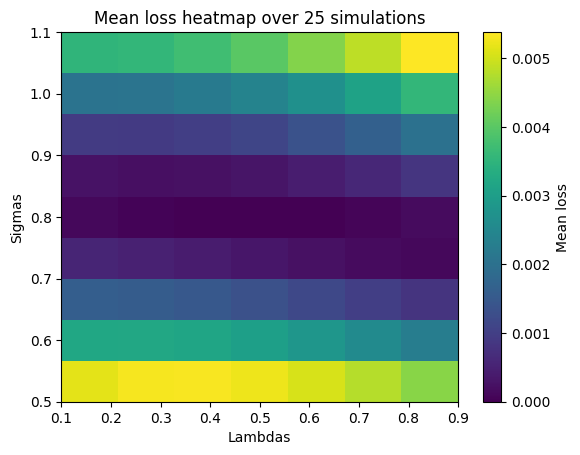

In [68]:
def complex_mse_loss(output):
    f1, csdx = csd(output, output, fs=100, noverlap=None,  window='hamming', scaling='density', nfft=4096, nperseg=1000)
    mse_real = torch.mean(torch.abs(torch.real(csdx) - torch.real(csdy))**2)
    mse_imaginary = torch.mean(torch.abs(torch.imag(csdx) - torch.imag(csdy))**2)
    loss = mse_real + mse_imaginary
    return loss


#fix alpha, change beta
# simulated signal -> alpha and beta 1 -> calculate csd
# observed_bold = np.loadtxt('./time_series/sub-001-PLCB-ROI0.txt', delimiter=',')
x_train_tensor, observed_bold  = getEulerBOLD(torch.tensor(0.8, requires_grad=True), torch.tensor(0.3, requires_grad=True), torch.tensor(0.5, requires_grad=True), 1.0, torch.tensor(1.0, requires_grad=True), True, 1000)

_, csdy = csd(observed_bold, observed_bold, fs=100, noverlap=None,  window='hamming', scaling='density', nfft=4096, nperseg=1000)

betas = np.arange(0.5, 1.5, 0.1)
mus = np.arange(0.1, 0.5, 0.1)
lambdas = np.arange(0.1, 1.0, 0.1)
sigmas = np.arange(0.5, 1.1, 0.1)
beta = 1.0
mu = 0.3
sigma = 0.8
lamb = 0.5
num_sims = 25

all_losses = np.zeros((len(lambdas), len(sigmas)))
for i in range(num_sims):
    print(i)
    losses = []
    for j, lamb in enumerate(lambdas):
        for k, sigma in enumerate(sigmas):
            _, bold = getEulerBOLD(torch.tensor(sigma), torch.tensor(mu), torch.tensor(lamb), 1.0, torch.tensor(beta), True, 1000)
            bold = torch.stack(bold)
            loss = complex_mse_loss(bold)
            all_losses[j, k] += loss.detach().numpy()


all_losses /= num_sims

# Plot heatmap
plt.imshow(all_losses, extent=[lambdas[0], lambdas[-1], sigmas[0], sigmas[-1]], aspect='auto', origin='lower')
plt.colorbar(label='Mean loss')
plt.xlabel('Lambdas')
plt.ylabel('Sigmas')
plt.title('Mean loss heatmap over 25 simulations')
plt.show()


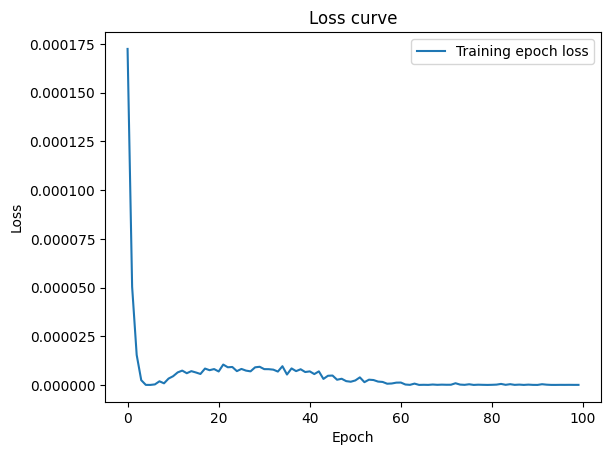

In [3]:
import json


# Read JSON file
with open('losses.json', 'r') as json_file:
    losses = json.load(json_file)


epochs = np.arange(len(losses))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.plot(epochs, losses, label='Training epoch loss')
plt.legend()
plt.show()